# Homework 4 : Curve Fitting

## Objectives

For the most part, this homework is more about learning and less about doing.  It is important to think about and understand what is presented here.  The main objectives of this homework are given below.
* Learn another way to avoid writing loops ourselves, even in cases when it looks like we would need to, by using the `np.vectorize()` function.
* Explore more carefully the meaning and use of the $\chi^2$, in particular the roles of the uncertainties.
* Learn more about reading data from the web using `urllib.request` along with the `with` statement.

## Initialization

As always you should add initialization to the top of your notebook.

In [1]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.special as sf
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

## Function vectorization

As we have seen, operating on an array of values is easier and more efficient than writing our own loop to evaluate the values one at a time.  When performing fits to data we must have a function that accepts and evaluates an array of input values.  Unfortunately there are some functions that do not work in this way.  Consider the example of a piecewise function; suppose we wish to evaluate 

$$ f(a, b) = \begin{cases} 
      a-b & a > b \\
      a+b & a \le b
   \end{cases}
$$ 

A simple way to implement this is given below.  It suffers from the limitation that we cannot pass arrays, `a` and `b`, to `f`.  In the past we would have written a loop to go through all the values of `x` and compute the function one value at a time.  An alternative approach is to let NumPy vectorize the function for us using `np.vectorize()`.

##### Study and Run the following example:

In [2]:
def f(a, b):
    "Return a-b if a>b, otherwise return a+b"
    if a > b:
        return a - b
    else:
        return a + b

# With this setup we can verify it works by doing, for example
f(1, 2)

3

So it works for a single value, this is not surprising.  On the other hand, it does not work if we pass in an array.  Instead we get a hard to understand error. 

In [3]:
a = np.linspace(1, 2, 10)
b = np.linspace(3, 4, 10)
# This should produce an error.
f(a, b)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

On the other hand, if we vectorize the code it magically works! There will always be cases where a function will not already be vectorized for us and `np.vectorize()` will be a convenient way to work around this.

In [4]:
# Instead we can define a new function F(x) using vectorize():
F = np.vectorize(f)
# Now ...
F(a, b)

array([4.        , 4.22222222, 4.44444444, 4.66666667, 4.88888889,
       5.11111111, 5.33333333, 5.55555556, 5.77777778, 6.        ])

It should be noted that `np.vectorize()` is not actually working magic and **does not make your code faster**, it is merely a convenience function that allows you to avoid explicitly writing a loop.  Essentially what it is doing is writing the loop for you.  It loops over your input arrays and executes the function once for each value in the arrays, collects these values, and returns them to you in a new array.  The case encountered here is one example where this is useful, and you may note is the first example in the documentation for `np.vectorize()`.

## Understanding $\chi^2$

We have introduced the $\chi^2$ and will use it to fit for parameters of a model given some data, but what is it really?  We know that given some data represented by the values $y_i$ and uncertainties $\sigma_i$ when evaluated at some points $x_i$ we can fit for the parameters, $\vec p$, of a model $f(x, \vec p)$.  Even if $f(x, \vec p)$ is a linear function of the parameters, $\vec p$, when there are more data points, $\vec y$, than there are parameters, $\vec p$, there will **not be a unique solution** for $\vec p$.  Instead we look for a set of parameters such that the curve described by the model is "close" to the data.  Many choices could be made to define what "close" means.  The one we make when performing least squares fitting is to minimize $\chi^2$ defined by

$$ \chi^2 = \sum_{i=1}^{n} \left( \frac{ y_i - f(x_i, \vec p) }{\sigma_i} \right)^2. $$

This choice makes some sense, it looks similar to the distance between points in Euclidean space (otherwise known as the Pythagorean theorem).

The $\chi^2$ is useful even without performing a fit.  Since it gives a measure of the "distance" between the data and a model, it can be used to quantify how "good a fit" the model is to the data.  Unfortunately this *is* the way it is phrased.  We talk about "goodness of fit" even when the $\chi^2$ is not minimized in order to find the best fit parameters.  In other words, $\chi^2$ can be used to perform model comparisons.  When we speak of the "goodness of fit" we mean the probability that the $\chi^2$ value would exceed the value calculated by chance for the number of degrees.  In statistics this is referred to as a one-sided $p$-value.  We will continue to call it the goodness of fit, but it is perhaps better to think of it as a $p$-value.

To get some practice and gain more familiarity with the $\chi^2$ value we will generate some fake data and analyze it.  You should think about each of the comparisons performed below to develop some intuition of what to look for in plots of data.  Essentially we want to gain some experience in performing "chi by eye", this means to get a rough idea of how well a model agrees with the data just by looking at plots.  This is a common thing to do when seeing data presented in talks or a paper!

### Generating Random Data

To begin, we generate some random data for the simple curve

$$ y(x; A, \phi) = A\sin(x+\phi) $$

with $A=4$ and $\phi=0.4$. We first generate random $x$ values in the range $0\le x<3\pi$.  With these we calculate the true values from the curve and then  generate random fluctuations to represent observational uncertainties.  Here we use Gaussian noise with a constant uncertainty for all observations $\sigma_y$.  (This is of course not necessary, it just makes the calculations a little easier.)

**Run the following cell.**  We want to use the same data for all our analysis below.  If you rerun this cell you will get new random data and must rerun all your analysis cells so that the results are consistent. (You are encouraged to generate and analyze a number of different sets of random data to see how the results can vary.)

In [5]:
# Generate random data.  Rerun all subsequent analysis cells after this.
A = 4.0
phi = 0.4
sigma_y = 2
x = np.random.rand(30) * 3*np.pi
def ymodel(x, A, phi) :
    return A*np.sin(x + phi)
ytrue = ymodel(x, A, phi)
y = ytrue + sigma_y * np.random.randn(len(x))

### True Model Comparison

For our random data we know the values of the parameters $A$ and $\phi$ from the true model.   We will use this to see what a "good" model should look like.

The first thing we should do is plot the data and a curve representing the true model.   Make a quick plot using `matplotlib.pyplot.errorbar` to plot both the data and a curve for the model. You should look up the documentation for the `errorbar` plotting function before using it.

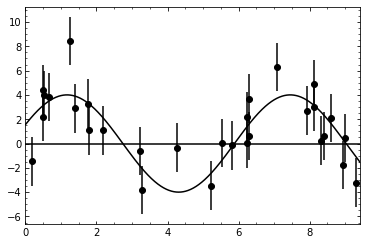

In [6]:
### BEGIN SOLUTION
plt.errorbar(x, y, yerr=sigma_y, fmt='ko')
xfine = np.linspace(0, 3*np.pi, 1000)
plt.plot(xfine, ymodel(xfine, A, phi), 'k-')
plt.axhline(0, color='k')
plt.xlim(0, 3*np.pi)
plt.minorticks_on()
### END SOLUTION

Calculate the $\chi^2$ using the true values for the parameters $A$ and $\phi$ in the model.  Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit. (*Hint:* We are **not** performing a fit so how many parameters are we allowing to vary and what does this mean for the number of degrees of freedom?)

In [7]:
### BEGIN SOLUTION
chisq = np.sum((y-ymodel(x, A, phi))**2/sigma_y**2)
dof = len(y)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""
True Model:
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")
### END SOLUTION


True Model:
chisq = 25.014517114993396
dof = 30
goodness of fit = 0.7243260707132222


### Uncertainties

The uncertainty, $\sigma_y$, plays a very important role in the fit.  It sets the scale for how accurately we know each data point and thus how much weight we should give to each data point.  In every case we have discussed, will encounter, and probably have encountered, we mean that the uncertainty "has the same units" as the data and is already "normalized" to the data.  It seems that there are other choices.  For example, the [weighted least squares](https://en.wikipedia.org/wiki/Weighted_least_squares) is one generalization.  Unfortunately, it seems this is the choice made as the default in `scipy.optimize.curve_fit`.  This choice means that **we must always use** `absolute_sigma=True`.  If we do not, the uncertainties in our fit parameters will not be reported correctly!

Even before we perform a fit, we can explore the role of uncertainties.  We may think it is best to *overestimate* the uncertainty "just to be safe".  Recalculate the $\chi^2$ now using twice the uncertainty, meaning replace $\sigma_y$ with $2 \sigma_y$ in your calculation.  Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for this case.  Also produce another quick plot of the data and the true model but now with the doubled uncertainty for the error bars on the data.


True Model:
chisq = 6.253629278748349
dof = 30
goodness of fit = 0.999998890605327


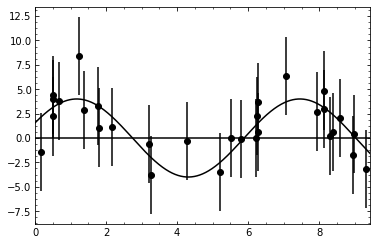

In [8]:
### BEGIN SOLUTION
chisq = np.sum((y-ymodel(x, A, phi))**2/(2*sigma_y)**2)
dof = len(y)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""
True Model:
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")
plt.errorbar(x, y, yerr=2*sigma_y, fmt='ko')
plt.plot(xfine, ymodel(xfine, A, phi), 'k-')
plt.axhline(0, color='k')
plt.xlim(0, 3*np.pi)
plt.minorticks_on()
### END SOLUTION

Based on the $\chi^2$, goodness of fit, **and from the plot itself** this result should not look correct. But the goodness of fit should be very, very close to one, why is this a problem?

We expect the $\chi^2$ to roughly equal the number of degrees of freedom.  A goodness of fit too close to one means the model is too good!  We see this from the plot in that the curve goes through (almost) all the error bars.  In practice it should only go through some of them (about 68 percent of them).  This suggests that either the error bars are too large, the uncertainties are not Gaussian distributed, or the data is faked!

Alternatively, we might want to "show off" how good we are at performing experiments and thus *underestimate* the uncertainties.  We also should also never do this!  Repeat the previous calculation now with $\sigma_y$ replaced by $\sigma_y/2$.  Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for this case.  Also produce another quick plot of the data and the true model but now with the halved uncertainty for the error bars on the data.


True Model:
chisq = 100.05806845997358
dof = 30
goodness of fit = 1.8180028383823457e-09


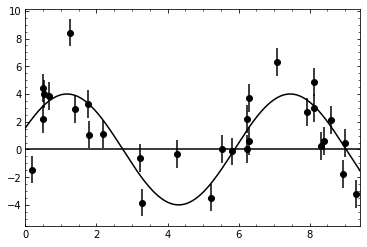

In [9]:
### BEGIN SOLUTION
chisq = np.sum((y-ymodel(x, A, phi))**2/(sigma_y/2)**2)
dof = len(y)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""
True Model:
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")
plt.errorbar(x, y, yerr=sigma_y/2, fmt='ko')
plt.plot(xfine, ymodel(xfine, A, phi), 'k-')
plt.axhline(0, color='k')
plt.xlim(0, 3*np.pi)
plt.minorticks_on()
### END SOLUTION

Based on the $\chi^2$, goodness of fit, and from the plot itself, we can see that this model also does not agree well with the data. We have the opposite problem now, the $\chi^2$ is too large, the goodness of fit is too small, and the curve for the model does not pass through most off the error bars.  (Again, the curve should pass through about 68 percent of the error bars.)  All of this means the data is not consistent with the model.

### Best Fit

Finally we *can* minimize the $\chi^2$ to find the best fit values for the parameters $A$ and $\phi$. It may come as a surprise to note that the best fit values are **not the true values**, even though we have generated fake data using particular values for the parameters, know the true errors, *etc*.  You should find the $\chi^2$ is smaller **but the goodness of fit may not be better** when the parameters take on values different than the true ones.  Further, the values of the parameters should be "close" to the true values with "close" here being defined by the uncertainties in the best fit parameter values.

Perform a fit to the model using `scipy.optmize.curve_fit`.  Do not forget to use `absolute_sigma=True`.  Print the best fit values for the parameters $A$ and $\phi$ along with their uncertainties.  Also print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for the parameters found from this fit. (*Hint:* Since the parameters are now being fit for, what should the number of degrees of freedom be?)

In [11]:
### BEGIN SOLUTION
# Note: sigma must be an array!
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y*np.ones_like(y),
                       absolute_sigma=True)
chisq = np.sum((y-ymodel(x, *p))**2/(sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
sigp = np.sqrt(np.diag(C))
print(f"""
Best Fit:
A = {p[0]} +/- {sigp[0]}
phi = {p[1]} +/- {sigp[1]}
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}
""".format(p, np.sqrt(np.diag(C)), chisq, dof, Q))
### END SOLUTION


Best Fit:
A = 3.9136728417035584 +/- 0.5553904014298542
phi = 0.5264623617749912 +/- 0.1238708984882838
chisq = 23.925664974973095
dof = 28
goodness of fit = 0.6854532688870661



Produce a nice figure showing the data with its errors bars.  Include in the figure a curve representing the true model and one representing the best fit model.  (*Note:* It may not be obvious that the best fit model has a small $\chi^2$, though it is worth staring at your figure to see that it seems plausible.  Depending on your random realization the two curves may or may not be very different.)

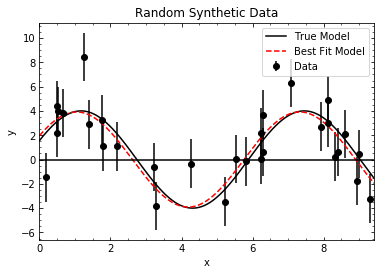

In [12]:
### BEGIN SOLUTION
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
ax.plot(xfine, ymodel(xfine, A, phi), 'k-', label='True Model')
ax.plot(xfine, ymodel(xfine, *p), 'r--', label='Best Fit Model')
ax.axhline(0, color='k')
ax.set_xlim(0, 3*np.pi)
ax.legend(loc='best', numpoints=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Random Synthetic Data')
ax.minorticks_on()
### END SOLUTION

### What did we just learn?

The calculations performed above are nice, but what do we learn from them?  The answer is somewhat subtle; such is the nature of statistics.  Since we are using random data, some of the small details of the calculations can change.  It is worthwhile to rerun the calculations for a few different data sets to see which results change and which do not.  (If you do this, make sure you leave your notebook in a state where all the calculations have been run for the same set of random data.)  We should find that the $\chi^2$ and goodness of fit for a model using the true parameters varies, perhaps even significantly.  On the other hand, doubling the error bars always leads to a goodness of fit extremely close to zero and halving the error bars always leads to a very poor goodness of fit.  Finally, the best fit parameters will not be the true values but will always be close (usually within 2 or 3 times the uncertainty in the parameters), the $\chi^2$ will be smaller than that from the model with the known parameters, but the goodness of fit will sometimes be smaller and sometimes be larger.

This last point may seem strange.  How can it be that we have the best fit parameters and yet the goodness of fit be worse?  The important point is that **when we perform a statistical calculation we are answering a specific question**.  We must clearly understand the question we are asking before we can interpret the results.  Further, if we ask a different question we will get a different answer and it is often difficult to know how to compare the results from two different statistical calculations.

In the calculations performed here we have asked two different questions.  In the first case we had a fixed model with **no free parameters**.  Here we were asking how close is the data to a particular model with particular values for the parameters.  In the second case we had a model with two parameters which could be optimized to find the values that best reproduce the data (best in the least squares sense).  Here we were asking for the best fit values of the parameters in our model given the data.  The "fitting" performed used some of the information in the data points to tune the values of the parameters, thus all of the data points were no longer independent pieces of information.  Since we were asking different questions it is not surprising that trying to compare the values for the goodness of fit between the two cases can be confusing.

Turning this around, comparing different cases such as we have here can be used to address the question of whether the data justifies (or needs) a more complicated model.  Do we need to add more parameters to the model and fit for their best values?  If adding more parameters does not worsen the goodness of fit then we are not justified in adding them.

## Loading Data from Text Files

Plain text files are a common way of storing data. They have the advantage of being very flexible, readable by anyone (you can directly look at it), and platform independent.  This flexibility comes at a cost: since they need not follow a rigid structure they can be difficult and slow to parse.

For simple, well formed text files NumPy provides the `loadtxt` function.  For more general text files we can instead use `genfromtxt`.  We will explore both of these functions below.

### Reading Data from the Web

We have previously seen that we can directly read data from the web using `urllib` without needing to download the file ourselves. We will similarly need to read a data file for this homework.

Given a url in a variable called `url` we can open the file as we saw in a previous assignment using
```
import urllib.request
fp = urllib.request.urlopen(url)
```
Though this works, it is not the best way to do things.

### The `with` Statement

The simple way we described things above is actually bad practice.  What we really should do when we open and read a file is
1. Open the file.
2. Check/catch any errors.
3. Read the data.
4. Close the file (that is, clean up after ourselves).

In general we do not do this, we just open the file, read it, and forget about it, hoping everything just worked.  Fortunately, there is an idiomatic way to do this more correctly in Python by using the `with` statement.  For our purpose the `with` statement just provides a local definition of some object, allows us to use it in a block of code, then cleans up this object after the block of code is executed.

We will use this below.  In our examples we will open the remote file using `urllib`, call this opened file `fp`, and then read it.  Once the code in the `with` block is done executing the object `fp` will no longer exist and cannot be used again.  It will be properly closed for us.  

### `loadtxt()`

There are a number of data sets available for extracting information about the expansion rate of the Universe from type Ia supernova data.  One such source is from [Pan-STARRS](https://archive.stsci.edu/prepds/ps1cosmo/).  Such sources give us detailed data for each supernova which would allow us to model their light curves, apply color corrections to calibrate them, *etc.*  While that would be essential if we were performing a careful scientific analysis of the data, that is not what we want to do here.  We will use a simpler (and a bit older) data set that has done some of the processing for us already.  We will only focus on the cosmology, not on the astrophysics.

Thus, the data we will use later comes from the Supernova Cosmology Project (the Union 2.1 set). It is stored in a text file that you may access from its original site at
http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt .

Note that this is an actual data file used in research projects.  See the [Supernova Cosmology Project page](http://supernova.lbl.gov/union/) for more information.  As noted above, we can directly read this data file from the web without having to download it!  To read a text file, `np.loadtxt` is the simplest choice.  It is meant to be used to read simple text files where the same number of data values are given in each line of the file.  This will mostly work in our case.

The code below is the general method for doing this.  You should see that it does not quite work, an exception is raised about a conversion error.

In [12]:
url = "http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt"
import urllib.request
with urllib.request.urlopen(url) as fp :
    X = np.loadtxt(fp)

ValueError: could not convert string to float: '1993ah'

The "problem" is that the first column contains strings (the names of the supernova).  Unfortunately `np.loadtxt()` assumes that all columns contain numbers.  Fortunately we can get around this by only reading in the columns we need.  In this case we will only use columns two, three, and four.

Modify the code above to allow us to read the datafile using `np.loadtxt()`, but only read in columns two, three, and four. Print to result to show that you have actually read in the correct data. (*Hint:* See the documentation for `np.loadtxt()` and pay particular attention to the `usecols` keyword.)

In [13]:
### BEGIN SOLUTION
with urllib.request.urlopen(url) as fp :
    X = np.loadtxt(fp, usecols=(1,2,3))
print(X)
### END SOLUTION

[[2.84880000e-02 3.53465834e+01 2.23905933e-01]
 [5.00430000e-02 3.66823679e+01 1.66828851e-01]
 [5.29260000e-02 3.68176913e+01 1.55755915e-01]
 ...
 [8.21000000e-01 4.36409388e+01 1.94013592e-01]
 [1.21500000e+00 4.52465209e+01 5.60317445e-01]
 [6.23000000e-01 4.25145240e+01 2.41428135e-01]]


### `genfromtxt()`

The more general, and thus more complicated, function for reading a text file is `genfromtxt`.  This can handle text files with different numbers of values on each line.  It has many, many options that can be used to read data from files even with crazy formatting choices.  **We do not need to use `genfromtxt()` for our data file.**  Even so, it is worth seeing what it does.  Run the following cell.

In [14]:
with urllib.request.urlopen(url) as fp :
    data = np.genfromtxt(fp)
print(data)

[[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
  1.28418942e-01]
 [           nan 5.00430000e-02 3.66823679e+01 1.66828851e-01
  1.28418942e-01]
 [           nan 5.29260000e-02 3.68176913e+01 1.55755915e-01
  1.28418942e-01]
 ...
 [           nan 8.21000000e-01 4.36409388e+01 1.94013592e-01
  5.51671793e-01]
 [           nan 1.21500000e+00 4.52465209e+01 5.60317445e-01
  1.47652666e-04]
 [           nan 6.23000000e-01 4.25145240e+01 2.41428135e-01
  5.51671793e-01]]


Notice that it read in the full file, filling in `nan` for the strings.  Not necessarily ideal, but at least it did read in all the numeric information.

For actual work, it would be far better to use Pandas for reading in and processing text or tabular data. In high-performance computing applications, other more efficient file formats are commonly used, including HDF (heirarchical data format) which can be accessed through the [h5py](https://docs.h5py.org/en/stable/) module, FITS files (flexable image transport system), which can be accessed through the [PyFITS](https://pyfits.readthedocs.io/en/latest/) module, and others. Database formats are also accessible through modules such as [MySQL](https://dev.mysql.com/doc/connector-python/en/), [SQLite](https://docs.python.org/3/library/sqlite3.html), and more.
These are large, powerful packages that we, unfortunately, will not have time to explore.



## Expansion Rate of the Universe

The 2011 Nobel prize in physics was awarded to Saul Perlmutter, Brian P. Schmidt, and Adam G. Riess "for the discovery of the accelerating expansion of the Universe through observations of distant supernovae". Using the data we have just loaded, we can perform our own analysis of a recent compilation of supernova data. As always there will be a few things we need to know before we look at the data.

Note that we are working with the real data provided by the observers! If you look at this file you will see it contains five columns. Columns two, three, and four we are interested in:
 * second column : redshift of the supernova ($z$),
 * third column : distance modulus ($\mu$, see below for a discussion of this),
 * fourth column : uncertainty in the distance modulus.

Below is a cell to read the data file and store the redshift, distance modulus, and the uncertainty in the distance modulus in arrays. We will use these arrays below. Here we take advantage of an additional unpack keyword, used to make storing the columns of data slightly easier.

In [15]:
with urllib.request.urlopen(url) as fp :
    (z, mu, sigmamu) = np.loadtxt(fp, usecols=(1,2,3), unpack=True)

### Cosmology

As we will discover, this data shows that the expansion rate of the Universe is accelerating. To do this we will fit for a couple cosmological parameters. The relevant parameters are $q_0$, the "acceleration parameter", and $h$, the reduced Hubble constant. A positive $q_0$ means we live in an accelerating universe, while a negative value indicates a decelerating universe.

To discover the acceleration we need to relate these parameters to the observations from the data file. Describing distances in an expanding universe is not as simple as in Euclidean space, so leads to more complicated looking equations. We will leave the details to a cosmology course, for our purposes we need to calculate the distance modulus.

The distance modulus, $\mu$, is a way of measuring the distance to an object in terms of its magnitude. It is given by

$$ \mu(z; h, q_0) = 43.23 - 5 \log_{10}\left(\frac{h}{0.7 z}\right) + 1.086 (1-q_0) z\,.$$

In the distance modulus the logarithm is base 10, not the natural logarithm. Recall that log returns the natural logarithm.
Keeping this in mind, define a function that will allow us to calculate the distance modulus for an array of redshift values. I recommend you define the distance modulus with default arguments as

    def distance_modulus(z, h=0.7, q0=0.0) :

This will be convenient in what follows.

In [16]:
### BEGIN SOLUTION
def distance_modulus(z, h=0.7, q0=0.0) :
    return 43.23 - 5.*np.log10(h/0.7/z) + 1.086*(1-q0)*z
### END SOLUTION

Fit this function for $q_0$ and $h$, using the `z`, `mu`, and `sigmamu` arrays. Print the best fit values, their uncertainties, and  the $\chi^2$ for the fit, the number of degrees of freedom, and the goodness of fit

In [1]:
### BEGIN SOLUTION
# Omega_de, w, and h
(p, C) = opt.curve_fit(distance_modulus, z, mu, sigma=sigmamu, p0=(0.7, 0.0),
                       absolute_sigma=True)
chisq_fit = np.sum((mu-distance_modulus(z,*p))**2/sigmamu**2)
dof_fit = len(z) - len(p)
Q_fit = 1.-sf.gammaincc(0.5*dof_fit, 0.5*chisq_fit)
sigp = np.sqrt(np.diag(C))
print(f"""
Fit to h and q0:
h  = {p[0]} +/- {sigp[0]}
q0 = {p[1]} +/- {sigp[1]}
chisq = {chisq_fit}
dof = {dof_fit}
goodness of fit = {Q_fit}""")
### END SOLUTION

NameError: name 'opt' is not defined

Let us put our results together into a single figure. Plot the data with error bars using `errorbar`. Include a line for the best fit model. Also include lines for a (relatively) large positive and negative acceleration parameter, with $(h, q_0) = (0.7, 1)$ and $(0.7, -1)$. You should see by eye that these other models do not fit the data well.

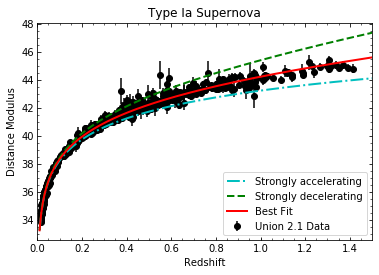

In [18]:
### BEGIN SOLUTION
fig = plt.figure()
ax = fig.add_subplot(111)
zgrid = np.linspace(0.01, 1.5, 200)

ax.errorbar(z, mu, yerr=sigmamu, fmt='ko', zorder=-1, label='Union 2.1 Data')
ax.plot(zgrid, distance_modulus(zgrid, 0.7, 1.0), 'c-.', label='Strongly accelerating', lw=2)
ax.plot(zgrid, distance_modulus(zgrid, 0.7, -1.0), 'g--', label='Strongly decelerating', lw=2)
ax.plot(zgrid, distance_modulus(zgrid, *p), 'r-', label='Best Fit', lw=2)

ax.set_xlabel('Redshift')
ax.set_ylabel('Distance Modulus')
ax.set_title('Type Ia Supernova')

ax.set_xlim(0, zgrid[-1])
ax.legend(numpoints=1, loc='best')
ax.minorticks_on()
### END SOLUTION

Although not conclusive, the $\chi^2$ and goodness of fit suggest $q_0 > 0$, so the supernova data require the expansion rate of our Universe to be accelerating. Working with a more complete model than we have used here, but also a much smaller set of supernova data, a similar conclusion was reached in 1998 resulting in a Nobel prize.